# Audio Classifier

In [1]:
from visualization import *
from datasets import *
from utils import *
from models import *

## Vowels dataset

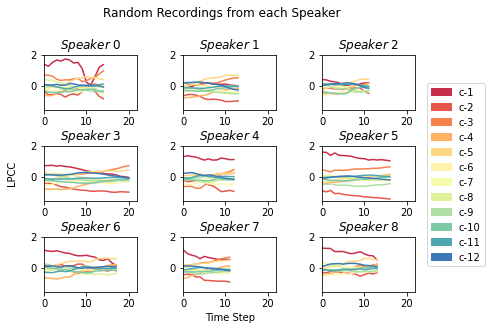

In [2]:
X_train_vowels, y_train_vowels, X_test_vowels, y_test_vowels = get_japanese_vowels()
plot_recordings(X_train_vowels)

Min length: 7 Max length: 26


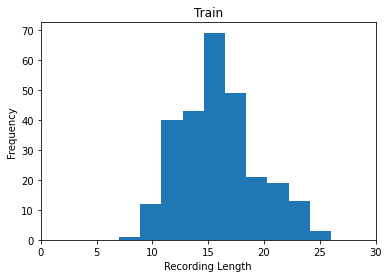

Min length: 7 Max length: 29


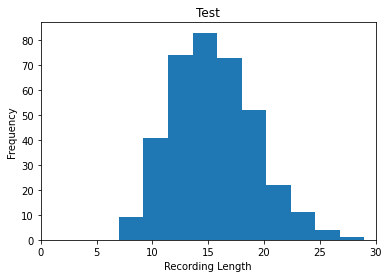

In [3]:
plot_rec_len_freq(X_train_vowels, "Train")
plot_rec_len_freq(X_test_vowels, "Test")

### CNN

In [3]:
X_train_vowels_uni, X_test_vowels_uni = pre_process(X_train_vowels, X_test_vowels, rec_len=30)
input_shape_vowels = (30, 12)

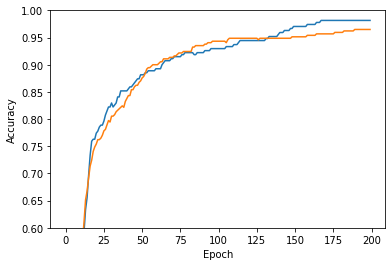

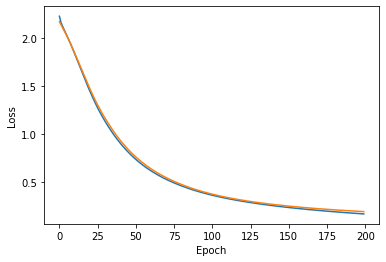

Test loss: 0.18740829825401306 / Test accuracy: 0.9648648500442505


In [5]:
# One model
history, cnn_model = train_cnn(input_shape_vowels, X_train_vowels_uni, y_train_vowels)
plot_cnn_training(history)
eval_cnn(cnn_model, X_test_vowels_uni, y_test_vowels)

# Cross-validation
cross_val_cnn(input_shape_vowels, X_train_vowels_uni, y_train_vowels, 5)

### RF

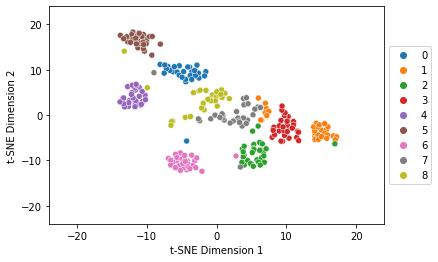

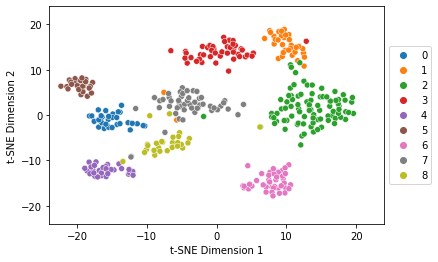

In [5]:
X_feat_train_vowels = extract_features(X_train_vowels_uni)
X_feat_test_vowels = extract_features(X_test_vowels_uni)
plot_tsne(X_feat_train_vowels, y_train_vowels)
plot_tsne(X_feat_test_vowels, y_test_vowels)

Accuracy 0.9783783783783784
F1-Score 0.9782804927223758


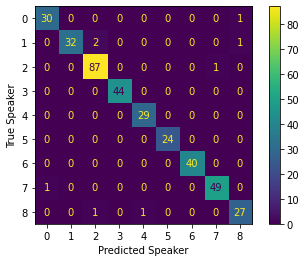

[[-0.0300102   1.78901655  0.09720775 ... -0.02900534 -0.08072035
   0.0858866 ]
 [ 0.04290466  1.47837355  0.13897315 ... -0.0042372   0.10454535
   0.02897384]
 [ 0.05004337  1.37187095  0.15072926 ... -0.00973284 -0.0701042
   0.03434686]
 ...
 [-0.0335897   1.26635055  0.10618651 ... -0.01216224  0.05113675
   0.03563513]
 [ 0.03387579  1.14285105  0.1294574  ... -0.01848651 -0.01680145
   0.05505391]
 [-0.00707547  1.21951157  0.02617169 ... -0.00610179  0.20921612
   0.01844968]] <class 'numpy.ndarray'>


TypeError: list indices must be integers or slices, not tuple

In [6]:
# One model
model = train_rf(X_feat_train_vowels, y_train_vowels)
cm = eval_rf(model, X_feat_test_vowels, y_test_vowels)
plot_rf_training(cm)

# Cross-validation
cross_val_rf(X_feat_train_vowels, y_train_vowels, 5)

---

## Digits dataset

In [8]:
X_digits, y_digits_num, y_digits_speaker = get_spoken_digits()
X_train_digits, X_test_digits, y_train_digits, y_test_digits = train_test_split(X_digits, y_digits_speaker, test_size=0.5, stratify=y_digits_speaker)

Min length: 9 Max length: 152


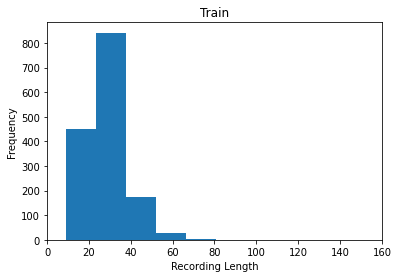

Min length: 9 Max length: 146


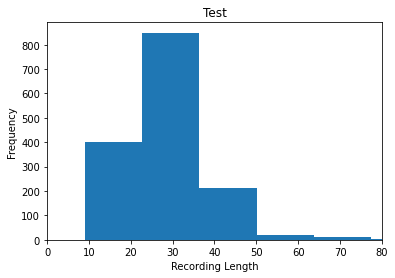

In [9]:
plot_rec_len_freq(X_train_digits, "Train", xmax=160)
plot_rec_len_freq(X_test_digits, "Test", xmax=80)

### CNN

In [10]:
X_train_digits_uni, X_test_digits_uni = pre_process(X_train_digits, X_test_digits, 50)
input_shape_digits = (50, 12)

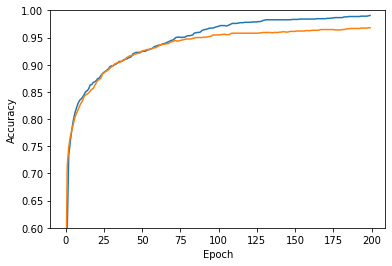

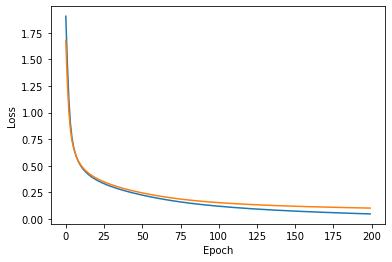

Test loss: 0.10328815877437592 / Test accuracy: 0.9679999947547913


In [11]:
# One model
history_digits, cnn_model_digits = train_cnn(input_shape_digits, X_train_digits_uni, y_train_digits)
plot_cnn_training(history_digits)
eval_cnn(cnn_model_digits, X_test_digits_uni, y_test_digits)

# Cross-validation
cross_val_cnn(input_shape_digits, X_train_digits_uni, y_train_digits, 5)

### RF

Accuracy 0.978
F1-Score 0.9779142613719368


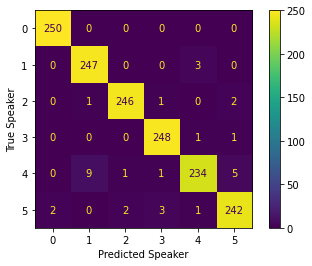

In [12]:
X_feat_train_digits = extract_features(X_train_digits_uni, n_windows=5)
X_feat_test_digits = extract_features(X_test_digits_uni, n_windows=5)

# One model
model = train_rf(X_feat_train_digits, y_train_digits)
cm = eval_rf(model, X_feat_test_digits, y_test_digits)
plot_rf_training(cm)

# Cross-validation
cross_val_rf(X_feat_train_digits, y_train_digits, 5)